In [1]:
import cv2
import numpy as np
import cv2 as cv
import colorsys
import sys

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


In [3]:
import os
import imageio
import numpy as np
from PIL import Image
from lxml import etree
import pandas as pd
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
#from utils.util_scripts import is_intersection

In [23]:
%matplotlib notebook

# Flame size

In [372]:
movie_path="C:/Users/user/PycharmProjects/fire_detector-3-1-1/fire_detector/videos/train/video_20210701_143239_1979/video_20210701_143239_1979.mp4"

In [374]:

cap=cv2.VideoCapture(movie_path)


frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

img_counter=0
FL_SIZE=30
max_leng=0
max_wid=0
CENTER=[]
LEFT=[]
#CENTER2=[]
av_cen=[]
av_factor=10
WID=[]
centroid_x=[]
m00=[]
m10=[]
not_flame=[]
flame=[]
fgbg = cv2.createBackgroundSubtractorMOG2()
not_flame_array=[]
flame_array=[]
sample_size=30
while(1):
    ret, frame = cap.read()
    #frame = fgbg.apply(frame) 
    img=frame[:,:,1]
    img[0:40, :] = 0
    img[frameHeight - 21:frameHeight - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frameWidth - 21:frameWidth - 1] = 0
    thresh, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv.morphologyEx(B2, cv.MORPH_CLOSE, np.ones((10, 10)))
    

    
    conturs, hierachy = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv.drawContours(frame, conturs, -1, (0,255,0), 3)
    con_id=0

    if conturs:
        for c in conturs:
        #c = max(conturs, key = cv2.contourArea)
            con_id=con_id+1
            
            top_point = (np.min(c[:, :, 0]), np.min(c[:, :, 1]))
            bottom_point = (np.max(c[:, :, 0]), np.max(c[:, :, 1]))
            box_im=B2[np.min(c[:, :, 1]):np.max(c[:, :, 1]),np.min(c[:, :, 0]):np.max(c[:, :, 0])]
            leng=np.max(c[:, :, 0])-np.min(c[:, :, 0])
            wid=np.max(c[:, :, 1])-np.min(c[:, :, 1])
            BSIZE=leng*wid
        
#             B4=img.copy() 
#             B4=cv.drawContours(B4, c, -1, (255,0,0), 1)
            if (BSIZE>100):
                M = cv2.moments(B2)
                cX = int(M["m10"]/ M["m00"])
                cY = int(M["m01"] / M["m00"])
        
                CX=cX#+np.min(c[:, :, 0])
                m00.append(int(M["m00"]))
                m10.append(int(M["m10"]))
            
            
                B3=img.copy() 
                frame = cv2.rectangle(B3, top_point,bottom_point, (255,0,0), 2)
                img=frame[:,:]
                center=np.min(c[:, :, 0])+0.5*(np.max(c[:, :, 0])-np.min(c[:, :, 0]))
                if center<900 and center >290:
                    not_flame.append(BSIZE)
                    if len(not_flame)>30:
                        not_flame_array.append(not_flame[-1*30:])
                    
                if center<620 and center >500:
                    
                    flame.append(BSIZE)
                    if len(flame)>FL_SIZE:
                        flame_array.append(flame[-1*FL_SIZE:])
                
#                 CENTER.append(center)
#                 LEFT.append(np.min(c[:, :, 0]))
        
#                 if len(CENTER)>av_factor:
#                     av_cen.append(sum(CENTER[-1*av_factor:])/av_factor)
#                 WID.append(leng)
#                 if leng>max_leng:
#                     max_leng=leng
            
#                 if leng>max_wid:
#                     max_wid=wid
            
                text= str(BSIZE)+'center:'+str(center) #str(leng)+' X '+str(wid)
                image = cv2.putText(frame, text, bottom_point,  cv2.FONT_HERSHEY_SIMPLEX,1, (255,0,0), 2, cv2.LINE_AA)
    text2= str(len(conturs)) #str(leng)+' X '+str(wid)
    
    image = cv2.putText(frame, text2, (100,100),  cv2.FONT_HERSHEY_SIMPLEX,1, (255,0,0), 2, cv2.LINE_AA)    
    prv = cv2.resize(B2, (1280, 960))
    cv2.imshow("preview",frame)
        
    k = cv.waitKey(30) & 0xff55
    if k == 27:
        break
    dbc=img_counter%4
    img_counter=img_counter+1
    #if img_counter==100:
    #    break
    

KeyboardInterrupt: 

In [375]:
cap.release()
cv.destroyAllWindows()  

In [127]:
#np.save('flame_3', np.array(flame_array))
#np.save('not_flame_2', np.array(not_flame_array))

In [385]:
np.array(not_flame_array).shape

(110, 30)

<IPython.core.display.Javascript object>


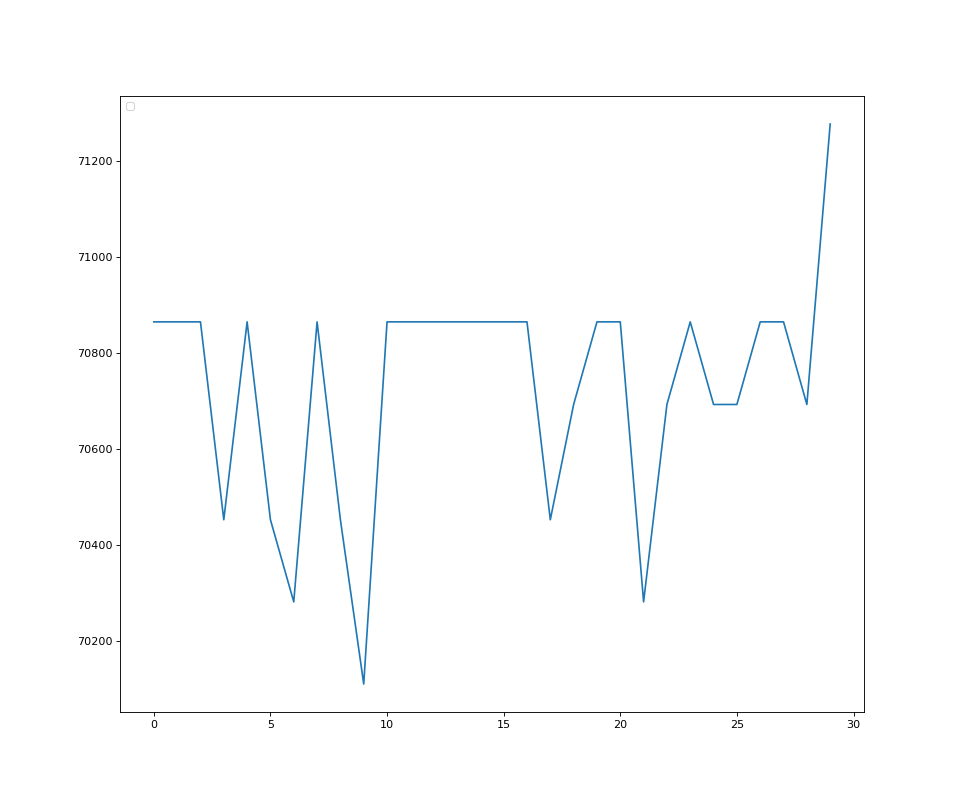

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [382]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.transpose(np.array(not_flame_array))[:,9])


plt.legend(loc="upper left")
#plt.ylim(750, 820)

<IPython.core.display.Javascript object>


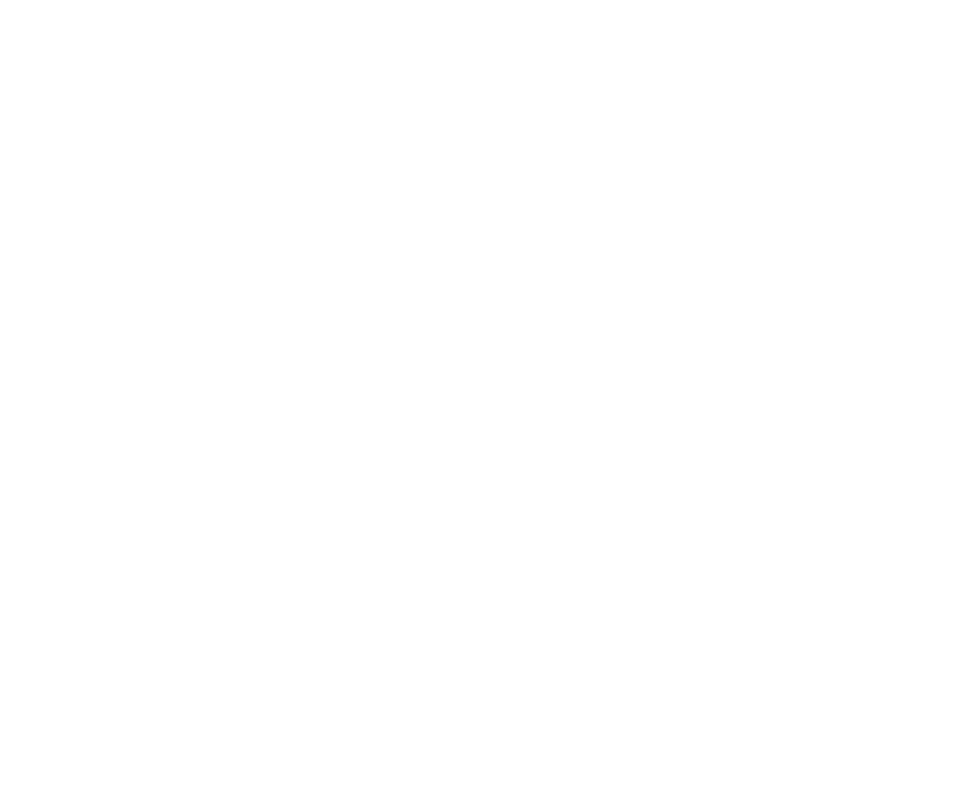

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [383]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.transpose(np.array(flame_array))[:,0])


plt.legend(loc="upper left")
#plt.ylim(750, 820)

<IPython.core.display.Javascript object>


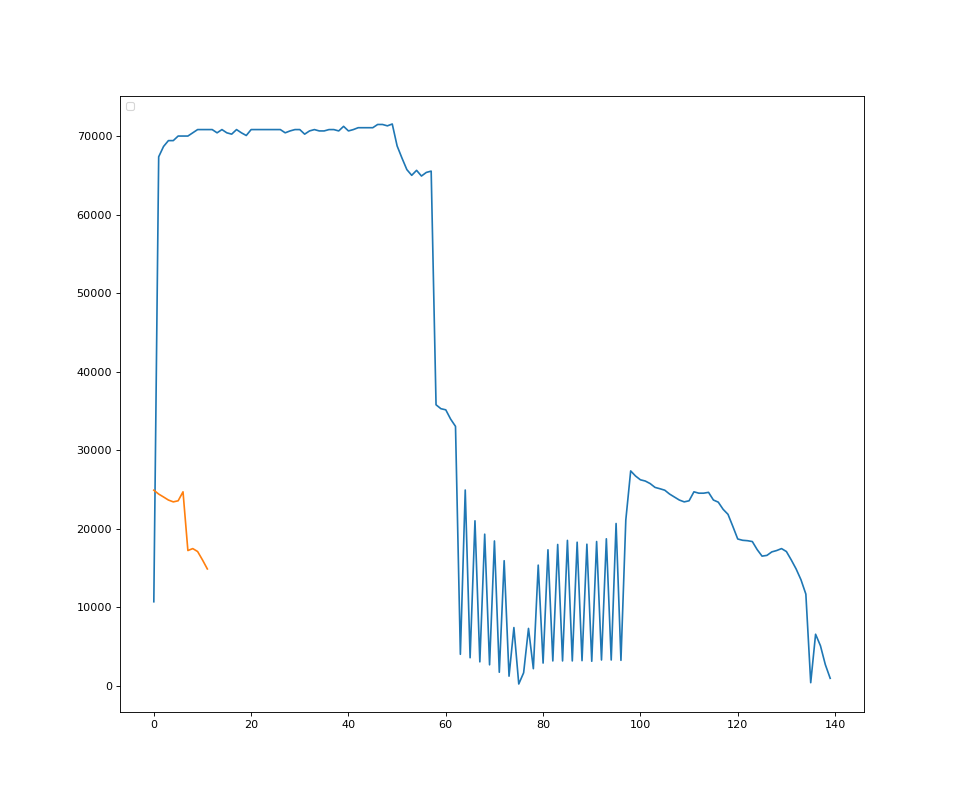

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [384]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


plt.plot(not_flame)
plt.plot(flame)


plt.legend(loc="upper left")
#plt.ylim(750, 820)

<IPython.core.display.Javascript object>


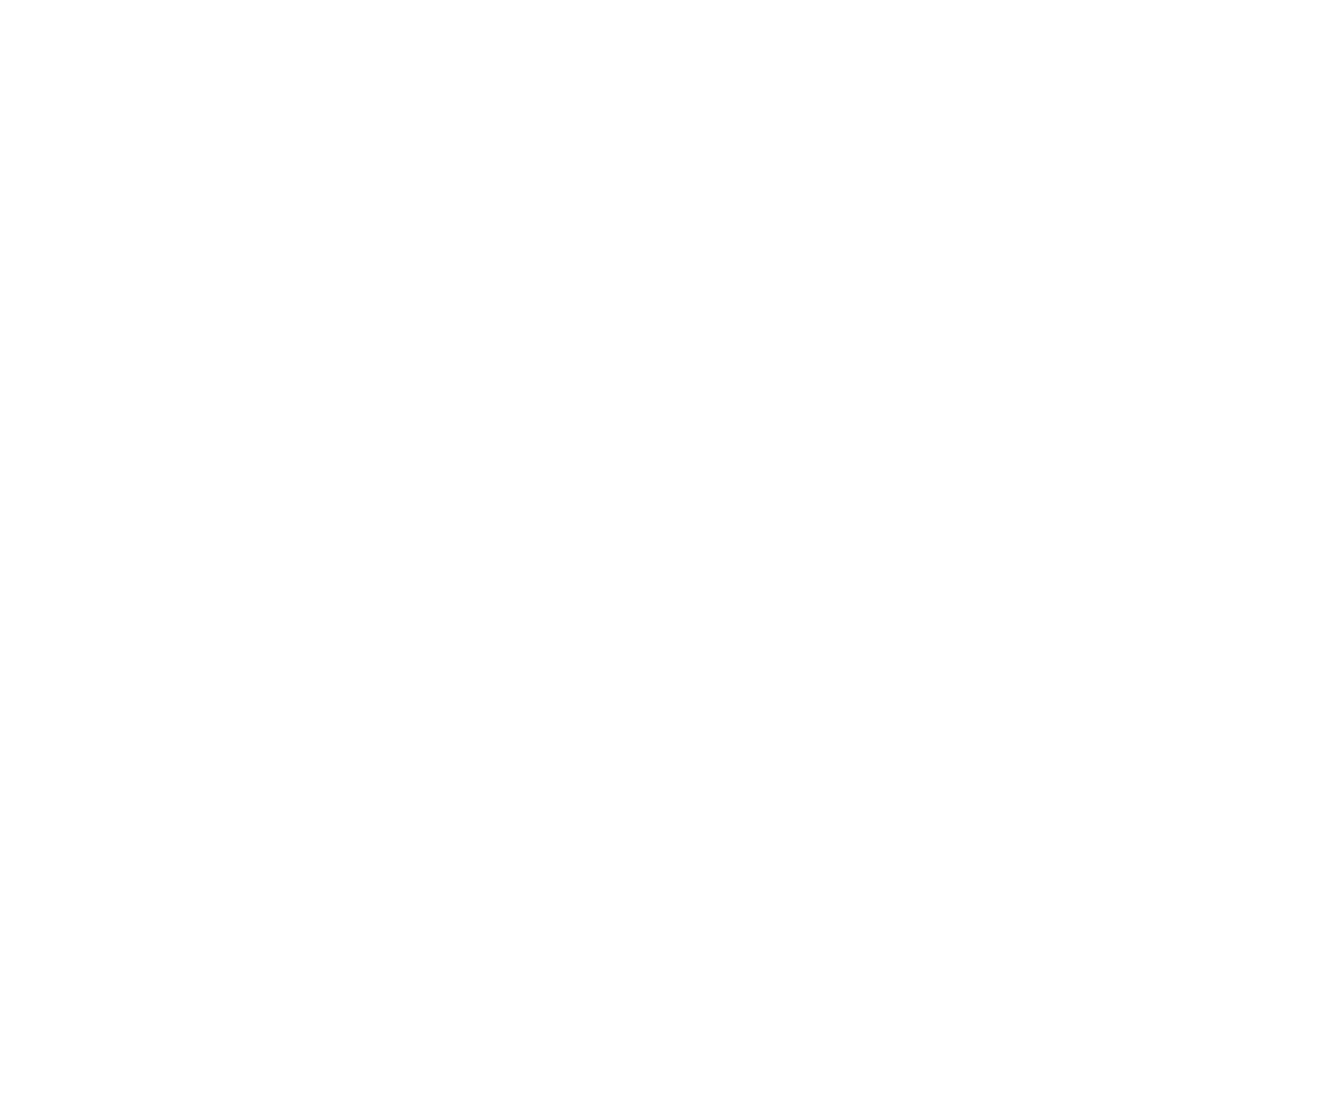

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [42]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(flame)


plt.legend(loc="upper left")
#plt.ylim(750, 820)

# Load


In [386]:
flame1=(np.load('flame_1.npy'))
nflame1=(np.load('not_flame_1.npy'))

flame2=(np.load('flame_2.npy'))
nflame2=(np.load('not_flame_2.npy'))

flame3=(np.load('flame_3.npy'))


In [387]:

flame_set=np.concatenate((flame1,flame2))
flame_set=np.concatenate((flame_set,flame3))


Not_flame_set=np.concatenate((nflame1,nflame2))
Not_flame_set=np.concatenate((Not_flame_set,not_flame_array))




In [388]:
flame_set.shape
flame_label=np.ones(flame_set.shape[0])
Not_flame_label=np.zeros(Not_flame_set.shape[0])

In [389]:
flame_label

array([1., 1., 1., ..., 1., 1., 1.])

In [390]:
Not_flame_set.shape

(3534, 30)

In [391]:
X_train=np.concatenate((flame_set,Not_flame_set))
Y_train=np.concatenate((flame_label,Not_flame_label))

In [392]:
X_train2=np.zeros(X_train.shape)

In [393]:
X_train[0][0]

128

In [394]:
X_train[0,:]

array([ 128,  108,  280,  532,  416,  325,  187,  814,  300,  336,  336,
        420,  680,  442,  494,  720, 1050,  493,  400,  308,  224,  228,
        135,  180,  228,  156,  224,  352,  325,  220])

In [395]:

for i in range (X_train.shape[0]):
    X_train2[i,:]=X_train[i,:]/np.max(X_train[i,:])

In [396]:
X_train[0,:]

array([ 128,  108,  280,  532,  416,  325,  187,  814,  300,  336,  336,
        420,  680,  442,  494,  720, 1050,  493,  400,  308,  224,  228,
        135,  180,  228,  156,  224,  352,  325,  220])

In [397]:
X_train2.shape

(6859, 30)

# AI

In [153]:
pip install keras


In [154]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [163]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [409]:
#  רשת א

def AI_model_Temporal_1():   # U
    #Create Model
    model = keras.models.Sequential([keras.Input(shape=(FL_SIZE,)),
                                 keras.layers.Dense(20, activation="relu"),
                                 keras.layers.Dropout(.1),
                                 keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(5, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid")
    ])
    

    sgd=keras.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False, name="SGD")
    adam=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99,epsilon=1e-07,amsgrad=False,name="Adam",)
    Binary_crossentropy=keras.losses.BinaryCrossentropy( from_logits=False, label_smoothing=0.5,axis=-1,reduction="auto",name="Binary_crossentropy",)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
    return model

In [410]:
model=AI_model_Temporal_1()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 20)                620       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_36 (Dense)            (None, 10)                210       
                                                                 
 dense_37 (Dense)            (None, 5)                 55        
                                                                 
 dense_38 (Dense)            (None, 1)                 6         
                                                                 
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


In [411]:
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
callbacks=[earlyStopping,reduce_lr_acc]

In [412]:
history=model.fit(X_train2, Y_train,batch_size=10, epochs=25,validation_split=0.2,shuffle='True')

Epoch 1/25
549/549 [==============================] - 2s 3ms/step - loss: 0.4570 - accuracy: 0.7653 - val_loss: 0.2760 - val_accuracy: 0.9541
Epoch 2/25
549/549 [==============================] - 1s 2ms/step - loss: 0.2066 - accuracy: 0.9107 - val_loss: 0.3728 - val_accuracy: 0.9512
Epoch 3/25
549/549 [==============================] - 1s 2ms/step - loss: 0.1751 - accuracy: 0.9278 - val_loss: 0.6546 - val_accuracy: 0.8943
Epoch 4/25
549/549 [==============================] - 1s 2ms/step - loss: 0.1827 - accuracy: 0.9245 - val_loss: 0.3550 - val_accuracy: 0.9461
Epoch 5/25
549/549 [==============================] - 1s 2ms/step - loss: 0.1785 - accuracy: 0.9269 - val_loss: 0.2911 - val_accuracy: 0.9490
Epoch 6/25
549/549 [==============================] - 1s 2ms/step - loss: 0.1595 - accuracy: 0.9318 - val_loss: 0.2597 - val_accuracy: 0.9534
Epoch 7/25
549/549 [==============================] - 1s 2ms/step - loss: 0.1454 - accuracy: 0.9413 - val_loss: 0.2407 - val_accuracy: 0.9570
Epoch 

<IPython.core.display.Javascript object>


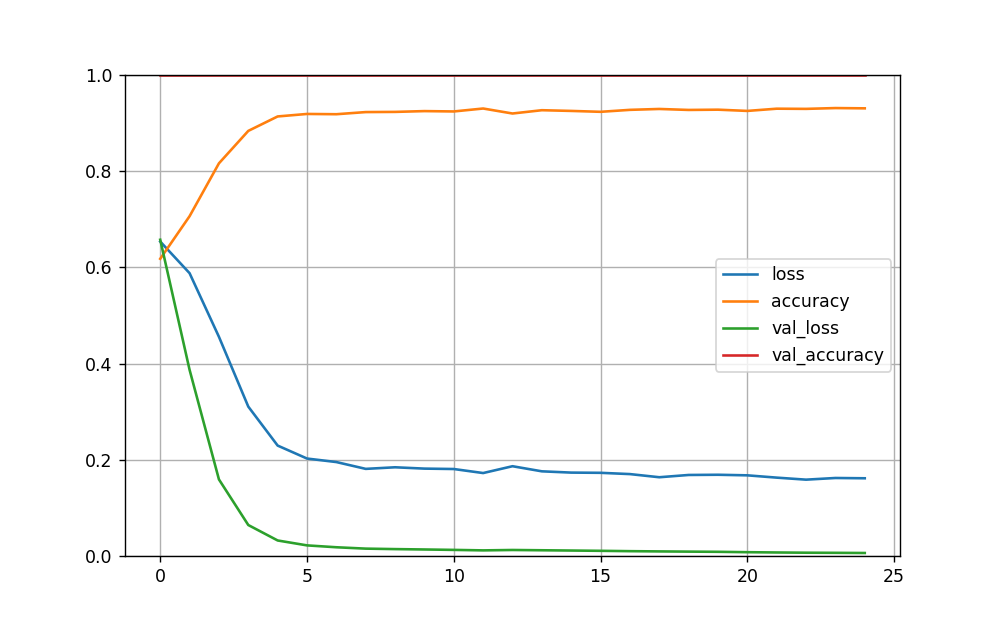

In [218]:

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) #  set  the  vertical  range  to  [0-1]
plt.show()

In [303]:
#model.save_weights('Temporal_Model_A_weights_V5.h5')


# Test

In [402]:
movie_path="C:/Users/user/PycharmProjects/fire_detector-3-1-1/fire_detector/videos/train/video_20210701_143239_1979/video_20210701_143239_1979.mp4"

In [403]:
cap.release()
cv.destroyAllWindows()  

In [ ]:

cap=cv2.VideoCapture(movie_path)



frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

img_counter=0
FL_SIZE=30
max_leng=0
max_wid=0
CENTER=[]
LEFT=[]
#CENTER2=[]
av_cen=[]
av_factor=10
WID=[]
centroid_x=[]
m00=[]
m10=[]
not_flame=[]
flame=[]
fgbg = cv2.createBackgroundSubtractorMOG2()
not_flame_array=[]
flame_array=[]
sample_size=30
textAI='None'
textAI1='None'
col=(255,0,0)
col1=(255,0,0)
while(1):
    ret, frame = cap.read()
    #frame = fgbg.apply(frame) 
    img=frame[:,:,1]
    img[0:40, :] = 0
    img[frameHeight - 21:frameHeight - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frameWidth - 21:frameWidth - 1] = 0
    thresh, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv.morphologyEx(B2, cv.MORPH_CLOSE, np.ones((200, 200)))
    

    
    conturs, hierachy = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv.drawContours(frame, conturs, -1, (0,255,0), 3)
    con_id=0

    if conturs:
        for c in conturs:
        #c = max(conturs, key = cv2.contourArea)
            con_id=con_id+1
            
            top_point = (np.min(c[:, :, 0]), np.min(c[:, :, 1]))
            bottom_point = (np.max(c[:, :, 0]), np.max(c[:, :, 1]))
            box_im=B2[np.min(c[:, :, 1]):np.max(c[:, :, 1]),np.min(c[:, :, 0]):np.max(c[:, :, 0])]
            leng=np.max(c[:, :, 0])-np.min(c[:, :, 0])
            wid=np.max(c[:, :, 1])-np.min(c[:, :, 1])
            BSIZE=leng*wid
        
#             B4=img.copy() 
#             B4=cv.drawContours(B4, c, -1, (255,0,0), 1)
            if (BSIZE>50):
                M = cv2.moments(B2)
                cX = int(M["m10"]/ M["m00"])
                cY = int(M["m01"] / M["m00"])
        
                CX=cX#+np.min(c[:, :, 0])
                m00.append(int(M["m00"]))
                m10.append(int(M["m10"]))
            
            
                B3=img.copy() 
                #frame = cv2.rectangle(frame, top_point,bottom_point, (255,0,0), 2)
                img=frame[:,:]
                center=np.min(c[:, :, 0])+0.5*(np.max(c[:, :, 0])-np.min(c[:, :, 0]))
                if center<200 :
                    not_flame.append(BSIZE)
                    if len(not_flame)>FL_SIZE:
                        input1=not_flame[-1*FL_SIZE:]
                        input1=input1/np.max(input1)
                        input2=np.expand_dims(input1, axis=0)
                        AI_output=(model.predict(input2))
                        AI_output=np.round(AI_output)[0][0]
                        if AI_output==1:
                            textAI='Fire'
                            col=(0,0,255)
                        if AI_output==0:
                            textAI='Not Fire'
                            col=(0,255,0)
                    image = cv2.putText(frame, textAI, bottom_point,  cv2.FONT_HERSHEY_SIMPLEX,1, col, 2, cv2.LINE_AA)
                        
                    
                if center >200:
    
                    flame.append(BSIZE)
                    if len(flame)>FL_SIZE:
                        input1=flame[-1*FL_SIZE:]
                        input1=input1/np.max(input1)
                        input2=np.expand_dims(input1, axis=0)
                        AI_output=(model.predict(input2))
                        AI_output=np.round(AI_output)[0][0]
                        if AI_output==1:
                            textAI1='Fire'
                            col1=(0,0,255)
                        if AI_output==0:
                            textAI1='Not Fire'
                            col1=(0,255,0)
                        image = cv2.putText(frame, textAI1, bottom_point,  cv2.FONT_HERSHEY_SIMPLEX,1, col1, 2, cv2.LINE_AA)
                        
                
            
                text= str(BSIZE)+'center:'+str(center) #str(leng)+' X '+str(wid)
                
    
    prv = cv2.resize(B2, (1280, 960))
    cv2.imshow("preview",frame)
        
    k = cv.waitKey(30) & 0xff55
    if k == 27:
        break
    dbc=img_counter%4
    img_counter=img_counter+1
    #if img_counter==100:
    #    break
    

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 10ms/step


Exception ignored in: <function UniquePtr.__del__ at 0x000001B72C8EBEE0>
Traceback (most recent call last):
  File "C:\Users\user\anaconda32\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 65ms/step


In [324]:
cap.release()
cv.destroyAllWindows()  